## Prepare stochastic programming modeling procedure
### Step 1
<ol>
<li>Read mean and variance for each hour of the day (e.g. summer).</li>
<li>Read aggregated nominal output power for each aggregator.</li>
<li>Select confidence factor.</li>
<li>From distribution select certain irradiance/speed and calculate the value which satisfies the confidence factor.</li>
<li>Calulate output power of the aggregated solar/wind installation.</li>
<li>Solve the bi-level model and obtain optimal values for controlled variables.</li>

### Step 2 - Monte Carlo
<li>Fix optimal control variables.</li>
<li>Relax network constraints (voltage and current).</li>
<li>Solve the problem many times by drawing random variables from given distribution.</li>
<li>Analyze the robustness of the solution by looking at how many times were network constraints violated.</li>
</ol>

In [124]:
from scipy.stats import norm, beta, weibull_min
from scipy.special import gamma
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import choices
plt.style.use({'figure.facecolor':'white'})


### Step 1 - without optimization

In [125]:
filename = 'Input_Files/InputData34.xlsx'
PVData = pd.read_excel(filename, sheet_name='PVData')
PVGeneration = pd.read_excel(filename, sheet_name='PVGeneration')
WindData = pd.read_excel(filename, sheet_name='WindData')
WindGeneration = pd.read_excel(filename, sheet_name='WindGeneration')

In [126]:
mu_st = {t:PVGeneration.loc[t, 'mean'] for t in PVGeneration.index}
var_st = {t:PVGeneration.loc[t, 'variance'] for t in PVGeneration.index}
mu_wt = {t:WindGeneration.loc[t, 'mean'] for t in WindGeneration.index}
var_wt = {t:WindGeneration.loc[t, 'variance'] for t in WindGeneration.index}
eta_conf = 55/100       #% confidence interval

wsin = 3                #Cut-in wind speed in (m/s)
wsr = 12                #Rated wind speed in (m/s)
wsout = 20              #Cut-off wind speed in (m/s)
Pwpp = 150              #Max. kW of aggregated wind
Ppv = 200               #Max. kW of aggregated solar

def renewable_sources(case):
    irrad = []; Ppvt = []
    wind = []; Pwt = []

    if case == 'Monte Carlo':
        for t in PVGeneration.index:
            if mu_st[t] == 0:
                irrad.append(0)
            else:
                b = (1 - mu_st[t])*(mu_st[t]*(1 + mu_st[t])/var_st[t] - 1)
                a = mu_st[t]*b/(1 - mu_st[t])
                irrad_spectrum = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
                irrad.append(choices(irrad_spectrum, beta.pdf(irrad_spectrum, a, b))[0])
            Ppvt.append(irrad[t]*Ppv)

        for t in WindGeneration.index:
            kappa = (np.sqrt(var_wt[t])/mu_wt[t])**(-1.086)
            lambd = mu_wt[t]/gamma(1 + 1/kappa)
            wind_spectrum = np.linspace(weibull_min.ppf(0.01, kappa, scale=lambd), weibull_min.ppf(0.99, kappa, scale=lambd), 100)
            wind.append(choices(wind_spectrum, weibull_min.pdf(wind_spectrum, kappa, scale=lambd))[0])
            #calculate output power of wind turbine as a function of wind speed
            if wind[t] < wsin:
                Pwt.append(0)
            elif wsin < wind[t] < wsr:
                Pwt.append(Pwpp*(wind[t]**3 - wsin**3)/(wsr**3 - wsin**3))
            elif wsr < wind[t] < wsout:
                Pwt.append(Pwpp)
            elif wind[t] > wsout:
                Pwt.append(0)
        return irrad, wind, Ppvt, Pwt

    elif case == 'Bilevel':
        for t in PVGeneration.index:
            if mu_st[t] == 0:
                irrad.append(0)
            else:
                b = (1 - mu_st[t])*(mu_st[t]*(1 + mu_st[t])/var_st[t] - 1)
                a = mu_st[t]*b/(1 - mu_st[t])
                irrad.append(beta.ppf(1 - eta_conf, a, b))
            Ppvt.append(irrad[t]*Ppv)

        for t in WindGeneration.index:
            kappa = (np.sqrt(var_wt[t])/mu_wt[t])**(-1.086)
            lambd = mu_wt[t]/gamma(1 + 1/kappa)
            wind.append(weibull_min.ppf(1 - eta_conf, kappa, scale=lambd))
            #calculate output power of wind turbine as a function of wind speed
            if wind[t] < wsin:
                Pwt.append(0)
            elif wsin < wind[t] < wsr:
                Pwt.append(Pwpp*(wind[t]**3 - wsin**3)/(wsr**3 - wsin**3))
            elif wsr < wind[t] < wsout:
                Pwt.append(Pwpp)
            elif wind[t] > wsout:
                Pwt.append(0)
        return irrad, wind, Ppvt, Pwt

    else:
        print('Invalid input!')

### Step 2 - without optimization

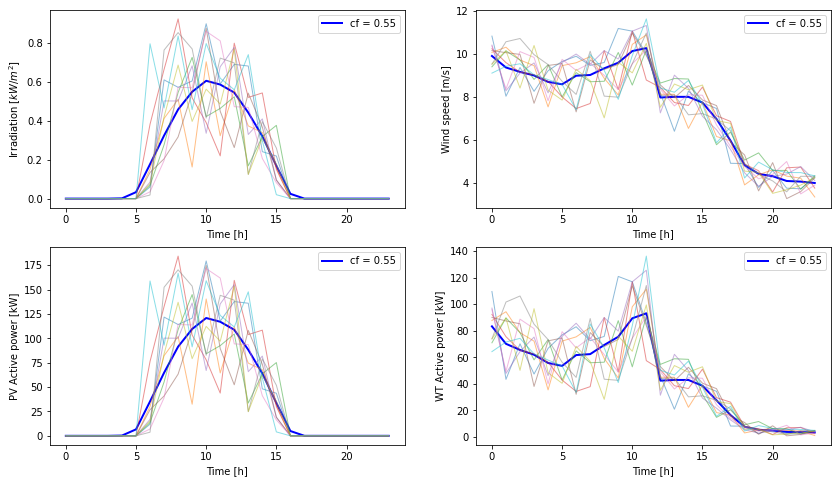

In [128]:
irrad, wind, Ppvt, Pwt = renewable_sources('Bilevel')

fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(14,8))
ax[0,0].plot(PVGeneration.index, irrad, 'b-', lw=2, alpha=1, label='cf = '+str(eta_conf));ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Irradiation [$kW/m^2$]');ax[0,0].legend()
ax[0,1].plot(WindGeneration.index, wind, 'b-', lw=2, alpha=1, label='cf = '+str(eta_conf));ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Wind speed [m/s]');ax[0,1].legend()

ax[1,0].plot(PVGeneration.index, Ppvt, 'b-', lw=2, alpha=1, label='cf = '+str(eta_conf));ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('Active power [kW]');ax[1,0].legend()
ax[1,1].plot(WindGeneration.index, Pwt, 'b-', lw=2, alpha=1, label='cf = '+str(eta_conf));ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('Active power [kW]');ax[1,1].legend();

for i in range(10):
    irrad, wind, Ppvt, Pwt = renewable_sources('Monte Carlo')

    ax[0,0].plot(PVGeneration.index, irrad, lw=1, alpha=0.5);ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Irradiation [$kW/m^2$]');ax[0,0].legend()
    ax[0,1].plot(WindGeneration.index, wind, lw=1, alpha=0.5);ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Wind speed [m/s]');ax[0,1].legend()

    ax[1,0].plot(PVGeneration.index, Ppvt, lw=1, alpha=0.5);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('PV Active power [kW]');ax[1,0].legend()
    ax[1,1].plot(WindGeneration.index, Pwt, lw=1, alpha=0.5);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('WT Active power [kW]');ax[1,1].legend();
